# RadioML dataset - 2016.10A
----

In [63]:
%matplotlib inline
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,8)
plt.rcParams.update({'font.size': 15})
plt.style.use('fivethirtyeight')

In [2]:
# Import the pickled raw file
path = "/Volumes/DHIRAJ/B.Tech/Project-1/RML2016.10a_dict.pkl"
with open(path, 'rb') as pic_file:
    data = pickle.load(pic_file, encoding='latin1')

In [19]:
print("Data is originally stored in a dictionary format with keys as (modulation and SNR value).")
print(f"Total labels: {len(data.keys())}")

Data is originally stored in a dictionary format with keys as (modulation and SNR value)
Total labels: 220


## Exploratory Data analysis
---

In [94]:
def plot_IQ_graph(samples, mod_name, SNR):    
    I_values = samples[0]
    Q_values = samples[1]
    plt.plot(I_values, label="I values")
    plt.plot(Q_values, label="Q values")
    plt.title(f"{mod_name}-{str(SNR)}")
    plt.legend()
    plt.show()

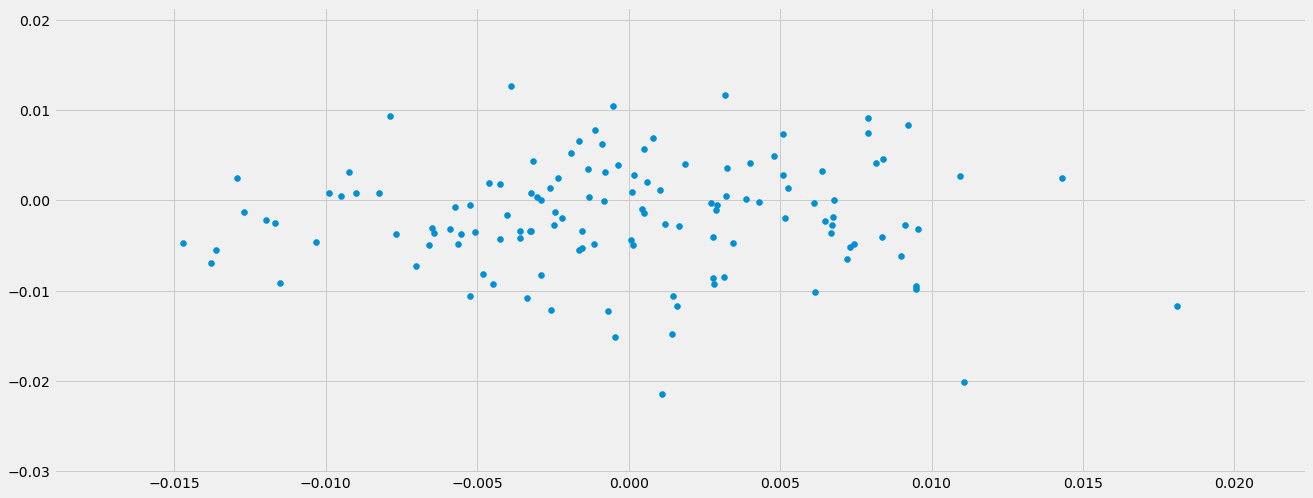

In [98]:
ex = data[("8PSK", 2)][0]
i = ex[0]
q = ex[1]
plt.scatter(i,q)

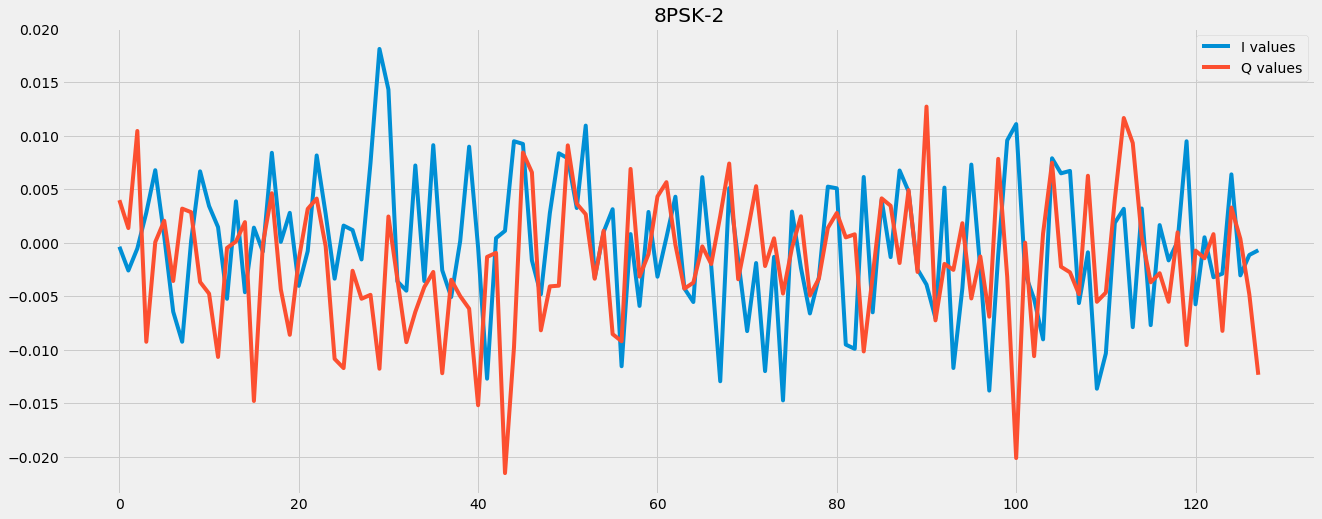

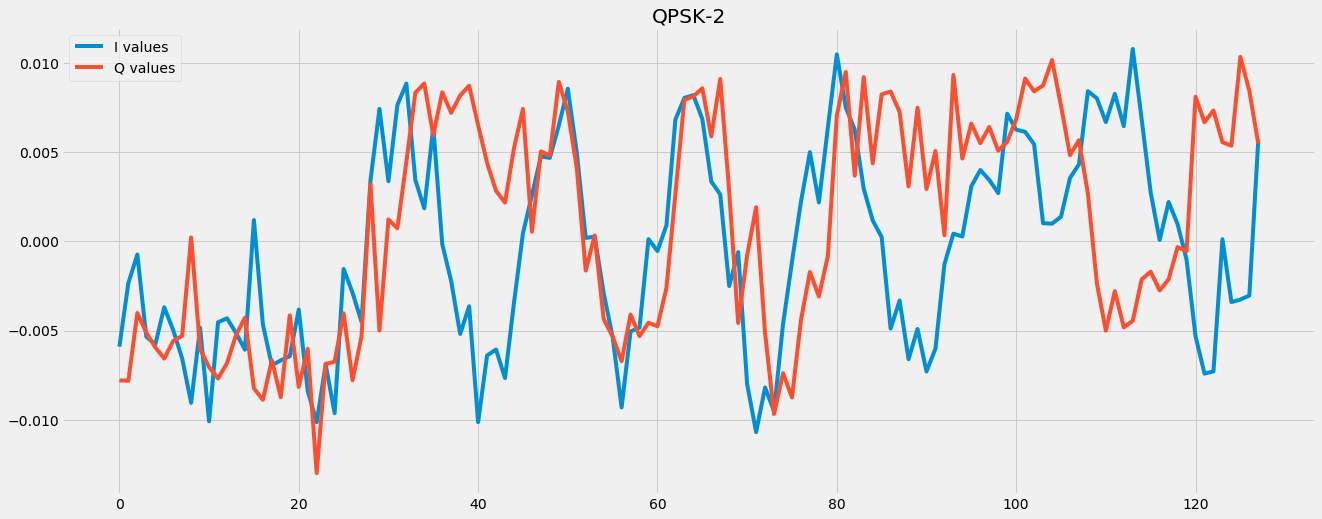

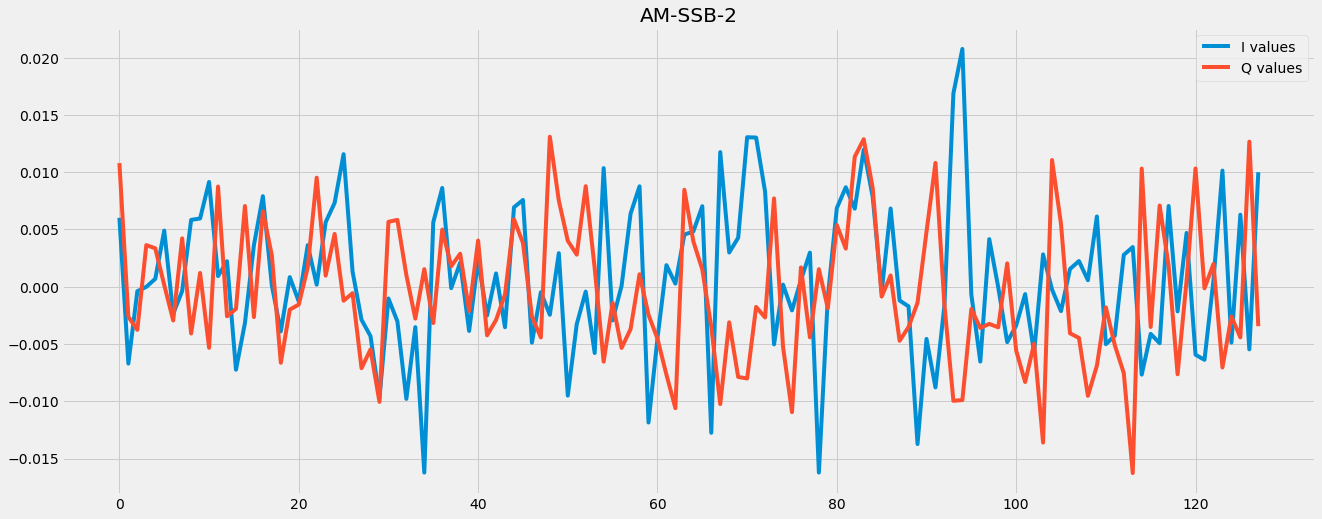

In [95]:
plot_IQ_graph(data[("8PSK", 2)][0], "8PSK", 2)
plot_IQ_graph(data[("QPSK", 2)][0], "QPSK", 2)
plot_IQ_graph(data[("AM-SSB", 2)][0], "AM-SSB", 2)

In [24]:
snrs, mods = map(lambda j: sorted(list(set(map(lambda x: x[j], data.keys())))), [1,0])
mods

['8PSK',
 'AM-DSB',
 'AM-SSB',
 'BPSK',
 'CPFSK',
 'GFSK',
 'PAM4',
 'QAM16',
 'QAM64',
 'QPSK',
 'WBFM']

In [45]:

i

array([-3.16330203e-04,  6.68360371e-05, -7.67900026e-04, -5.75584068e-04,
       -5.58358035e-04,  1.42504781e-04,  2.32233971e-04,  4.71866631e-04,
       -2.07809891e-04,  5.04389231e-04,  1.87691228e-06, -2.89246935e-04,
       -2.00416034e-04, -1.46032151e-04,  2.09888531e-05, -3.43978463e-04,
        9.74379131e-04, -2.90188007e-04, -5.44920214e-04, -5.10226819e-04,
       -3.40444269e-04, -2.90281750e-04,  1.41299295e-03, -2.14083353e-04,
        9.18152073e-05, -2.40329318e-04,  1.75515030e-04, -2.07382211e-04,
        3.57897778e-04, -1.69128281e-04,  1.61918404e-04, -3.65153654e-04,
       -1.79499897e-04, -4.20442986e-04,  2.43515955e-04,  3.79152189e-04,
       -1.10484063e-04,  6.52982795e-04, -1.51713422e-04, -4.92653693e-04,
        1.79613722e-04, -3.58996360e-04, -7.24761747e-04,  5.09331061e-04,
        1.10875897e-03, -3.12905206e-04,  9.67597589e-05, -1.53405534e-04,
        2.69056909e-04, -2.77518673e-04,  5.67789073e-04,  5.03931602e-04,
        1.78168906e-04, -

In [39]:
data[('BPSK', 18)][0][1]

array([ 1.40152100e-04, -1.91981337e-04, -3.76533455e-04, -3.29711154e-04,
       -4.10497363e-04,  5.50677127e-04,  1.06949173e-03, -4.07535379e-04,
        6.65662403e-04,  1.48494219e-04, -2.38515291e-04, -1.24393700e-04,
       -3.90601752e-04,  4.43283847e-04,  1.18941336e-03, -5.49747259e-04,
        2.58357002e-04, -2.11945910e-04,  1.77725378e-04, -5.92785887e-04,
        7.66120211e-04,  2.10501050e-04, -8.48509953e-04,  4.53616740e-05,
       -1.43690512e-03,  7.11854591e-05,  5.74454607e-04, -4.64119221e-04,
        6.61479076e-04,  1.66858168e-04, -3.29848990e-04, -2.26671313e-04,
       -2.10263461e-04, -7.84310105e-04,  1.50027117e-04, -1.86760044e-05,
       -9.30319191e-04, -2.11888822e-04,  1.76818958e-05, -5.15824417e-04,
       -3.85760854e-04,  7.20287440e-04, -1.65663107e-04,  9.32316878e-04,
        2.50317971e-04, -7.72581843e-05, -9.27256653e-04, -4.56309615e-04,
       -2.37789471e-04, -3.02295957e-04, -5.38749038e-04,  6.15608355e-04,
        3.46423592e-04,  